In [8]:
# import libraries
import torch.nn as nn
import pandas as pd
import json
import os
import numpy as np
import pickle
import json
import scipy
import plotly.io as pio
from torch.utils.data import Dataset, DataLoader
import torch
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import plotly.express as px

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

# ignore warnings jupyter notebook
import warnings
warnings.filterwarnings('ignore')

In [9]:
# load config file
with open('../utils/configs.json') as f:
    config = json.load(f)

# ---------------------------- Functions ---------------------------- 

In [10]:
# base df for hague merge contains all the dates between start and end date with 5 minutes interval
def base_df(start_date = '2018-01-01', end_date = '2021-04-02'):
    # generate all the dates between start and end date with 5 minutes interval
    dates = pd.date_range(start_date, end_date, freq='5min')
    df = pd.DataFrame(index=dates)
    df.index.name = 'timestamp'
    return df

In [11]:
# base df for metr data 
def base_df_metr(start_date = '2012-02-05', end_date = '2012-07-28'):
    # generate all the dates between start and end date with 5 minutes interval
    dates = pd.date_range(start_date, end_date, freq='5min')
    df = pd.DataFrame(index=dates)
    df.index.name = 'timestamp'
    return df 

In [12]:
# base dataframe for bay area
def base_df_bay(start_date = '2017-01-01', end_date = '2017-12-01'):
    # generate all the dates between start and end date with 5 minutes interval
    dates = pd.date_range(start_date, end_date, freq='5min')
    df = pd.DataFrame(index=dates)
    df.index.name = 'timestamp'
    return df 

# ---------------------------- MAIN ---------------------------- 

## ---------------------------- Hague Correlation Processing ---------------------------- 

In [13]:
# declare the variables
data_name = 'hague'
# MODELS = ["AE", "DAE", "HST", "PW-AE", "xStream", "Kit-Net", "ILOF"]
MODELS = ["AE","DAE","PW-AE"]
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9, 1] # thresholds for the top-k sensors
earths_movers_distance = False

In [ ]:
for model_name in MODELS:
    print(f"processing data {data_name} and model - {model_name} ")
    model_name = model_name
    outlier_score_path = f'../results/{data_name}/outlier_scores/{model_name}'  # path to outlier scores
    if earths_movers_distance:
        outlier_score_path = outlier_score_path + "_EMD"
    correlated_results = {}
    # for each trajectory, direction and intersection, run AE model
    for trajectory in config['trajectories']:
        for direction in config['trajectories'][trajectory]:
            key = trajectory+'_'+direction
            correlated_results[key] = {}
            df = base_df()
            for intersection in config['trajectories'][trajectory][direction]:
                file_path = os.path.join(outlier_score_path,intersection+'_'+direction+'.csv')
                df_intersection = pd.read_csv(file_path) # load outlier scores
                df_intersection['timestamp'] = pd.to_datetime(df_intersection['timestamp']) # convert timestamp to datetime
                df_intersection.set_index('timestamp',inplace=True) # set timestamp as index
                df_intersection = df_intersection.rename(columns={'outlier_score':intersection})
                df = df.merge(df_intersection, on='timestamp', how='inner') # merge outlier scores with base df

            normalized_df=(df-df.min())/(df.max()-df.min()) # apply min-max normalization
            correlated_results[key] = normalized_df # save the results in a dictionary


    # save the results as pickle file
    file_name = f'../results/{data_name}/outlier_scores/{model_name}/correlated_results.pickle'
    if earths_movers_distance:
        file_name = f'../results/{data_name}/outlier_scores/{model_name}_EMD/correlated_results.pickle'
    
    with open(file_name, 'wb') as f:
        pickle.dump(correlated_results,f)

## ---------------------------- METR-LA Correlation Processing ---------------------------- 

In [15]:
# declare the variables
data_name = 'METR-LA'
# MODELS = ["AE", "DAE", "HST", "PW-AE", "xStream", "Kit-Net", "ILOF"]
MODELS = ["AE","DAE","PW-AE"]
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9, 1]
earths_movers_distance = True

In [ ]:
for model_name in MODELS:
    print(f"processing data {data_name} and model - {model_name} ")
    model_name = model_name
    outlier_score_path = f'../results/{data_name}/outlier_scores/{model_name}'  # path to outlier scores
    if earths_movers_distance:
        outlier_score_path = outlier_score_path + "_EMD"
    correlated_results = {}
    # for each trajectory, direction and intersection, run AE model
    df = base_df_metr()
    for intersection in os.listdir(outlier_score_path):
        if intersection.endswith('.csv'):
            intersection = intersection.split('.')[0]
            file_path = os.path.join(outlier_score_path,intersection+'.csv')
            df_intersection = pd.read_csv(file_path) # load outlier scores
            df_intersection['timestamp'] = pd.to_datetime(df_intersection['timestamp']) # convert timestamp to datetime
            df_intersection.set_index('timestamp',inplace=True) # set timestamp as index
            df_intersection = df_intersection.rename(columns={'outlier_score':intersection})
            df = df.merge(df_intersection, on='timestamp', how='inner') # merge outlier scores with base df
    # save the results
    normalized_df=(df-df.min())/(df.max()-df.min()) # apply min-max normalization
    correlated_results['df']= normalized_df


    # save the results as pickle file
    file_name = f'../results/{data_name}/outlier_scores/{model_name}/correlated_results.pickle'
    if earths_movers_distance:
        file_name = f'../results/{data_name}/outlier_scores/{model_name}_EMD/correlated_results.pickle'

    with open(file_name, 'wb') as f:
        pickle.dump(correlated_results,f)

## ---------------------------- PEMS-BAY Correlation Processing ---------------------------- 

In [18]:
# declare the variables
data_name = 'PEMS-BAY'
# MODELS = ["AE", "DAE", "PW-AE", "HST", "Kit-Net", "ILOF"]
MODELS = ["AE", "DAE", "PW-AE"]
# thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9, 1]
earths_movers_distance = False

In [ ]:
for model_name in MODELS:
    print(f"processing data {data_name} and model - {model_name} ")
    model_name = model_name
    outlier_score_path = f'../results/{data_name}/outlier_scores/{model_name}'  # path to outlier scores
    if earths_movers_distance:
        outlier_score_path = outlier_score_path + "_EMD"
    correlated_results = {}
    # for each trajectory, direction and intersection, run AE model
    df = base_df_bay()
    for intersection in os.listdir(outlier_score_path):
        if intersection.endswith('.csv'):
            intersection = intersection.split('.')[0]
            file_path = os.path.join(outlier_score_path,intersection+'.csv')
            df_intersection = pd.read_csv(file_path) # load outlier scores
            df_intersection['timestamp'] = pd.to_datetime(df_intersection['timestamp']) # convert timestamp to datetime
            df_intersection.set_index('timestamp',inplace=True) # set timestamp as index
            df_intersection = df_intersection.rename(columns={'outlier_score':intersection})
            df = df.merge(df_intersection, on='timestamp', how='inner') # merge outlier scores with base df
            # change the column name to strings
            df = df.rename(columns={intersection: str(intersection)})

    # save the results
    normalized_df=(df-df.min())/(df.max()-df.min()) # apply min-max normalization
    correlated_results['df']= normalized_df


    # save the results as pickle file
    file_name = f'../results/{data_name}/outlier_scores/{model_name}/correlated_results.pickle'
    if earths_movers_distance:
        file_name = f'../results/{data_name}/outlier_scores/{model_name}_EMD/correlated_results.pickle'

    with open(file_name, 'wb') as f:
        pickle.dump(correlated_results,f)

# DATA ANALYSIS

## ------- 1. Correlation analysis Hague data -------

<!-- 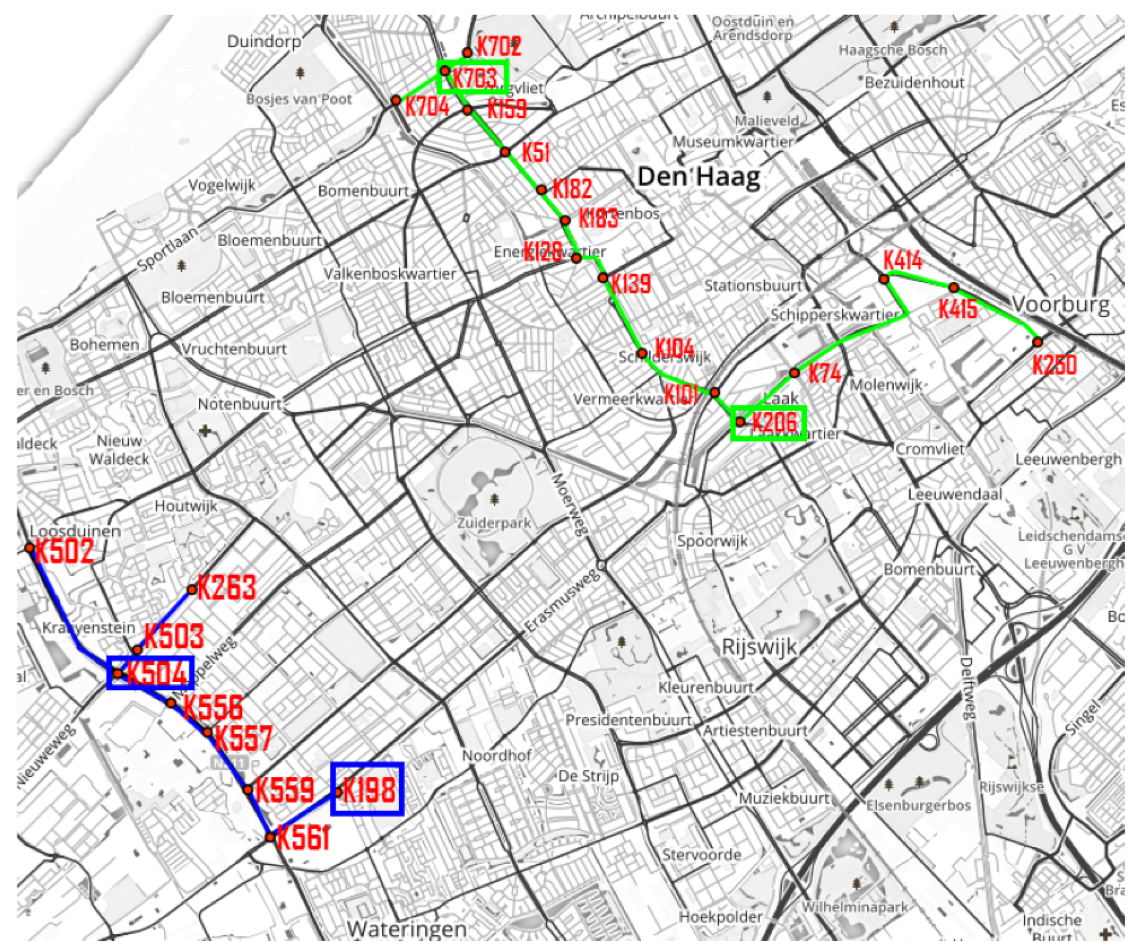 -->
<img src="plots/intersection selected.jpeg" alt="image" width="600">

In [43]:
# load the outlier score for haugue dataset
data_name = 'hague'
model_name = 'PW-AE_EMD'
with open(f'../results/{data_name}/outlier_scores/{model_name}/correlated_results.pickle', 'rb') as f:
    correlated_results = pickle.load(f)

# load the outlier score for hague dataset
df_t1_north = correlated_results['T1_North']
df_t1_south = correlated_results['T1_South']
df_t2_north = correlated_results['T2_North']
df_t2_south = correlated_results['T2_South']

In [47]:
# check the correlation between the K504 and other variables
df_t1_north.corr()['K504'].sort_values(ascending=False) # sort the series

K504    1.000000
K502    0.325564
K198    0.309157
K559    0.298911
K561    0.244559
K263    0.242935
K556    0.205765
K503    0.189974
K557    0.187595
Name: K504, dtype: float64

In [48]:
df_t1_north.corr()['K504'].sort_values(ascending=True) # sort the series
# sort the series

K557    0.187595
K503    0.189974
K556    0.205765
K263    0.242935
K561    0.244559
K559    0.298911
K198    0.309157
K502    0.325564
K504    1.000000
Name: K504, dtype: float64

In [61]:
# plot the correlation between K504, K502, K557
temp = df_t1_north.iloc[5000:,]
sample_df = temp.head(24*7)
fig = px.line(sample_df, x=sample_df.index, y=['K504','K502','K557'], title='speed analysis')
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.update_yaxes(title_text="outlier score of PW-AE")

In [63]:
# heatmap
px.imshow(df_t1_north.corr().round(2), text_auto=True, height=600, width=600)

## --------- 2. Correlation analysis METR-LA ---------

<!-- 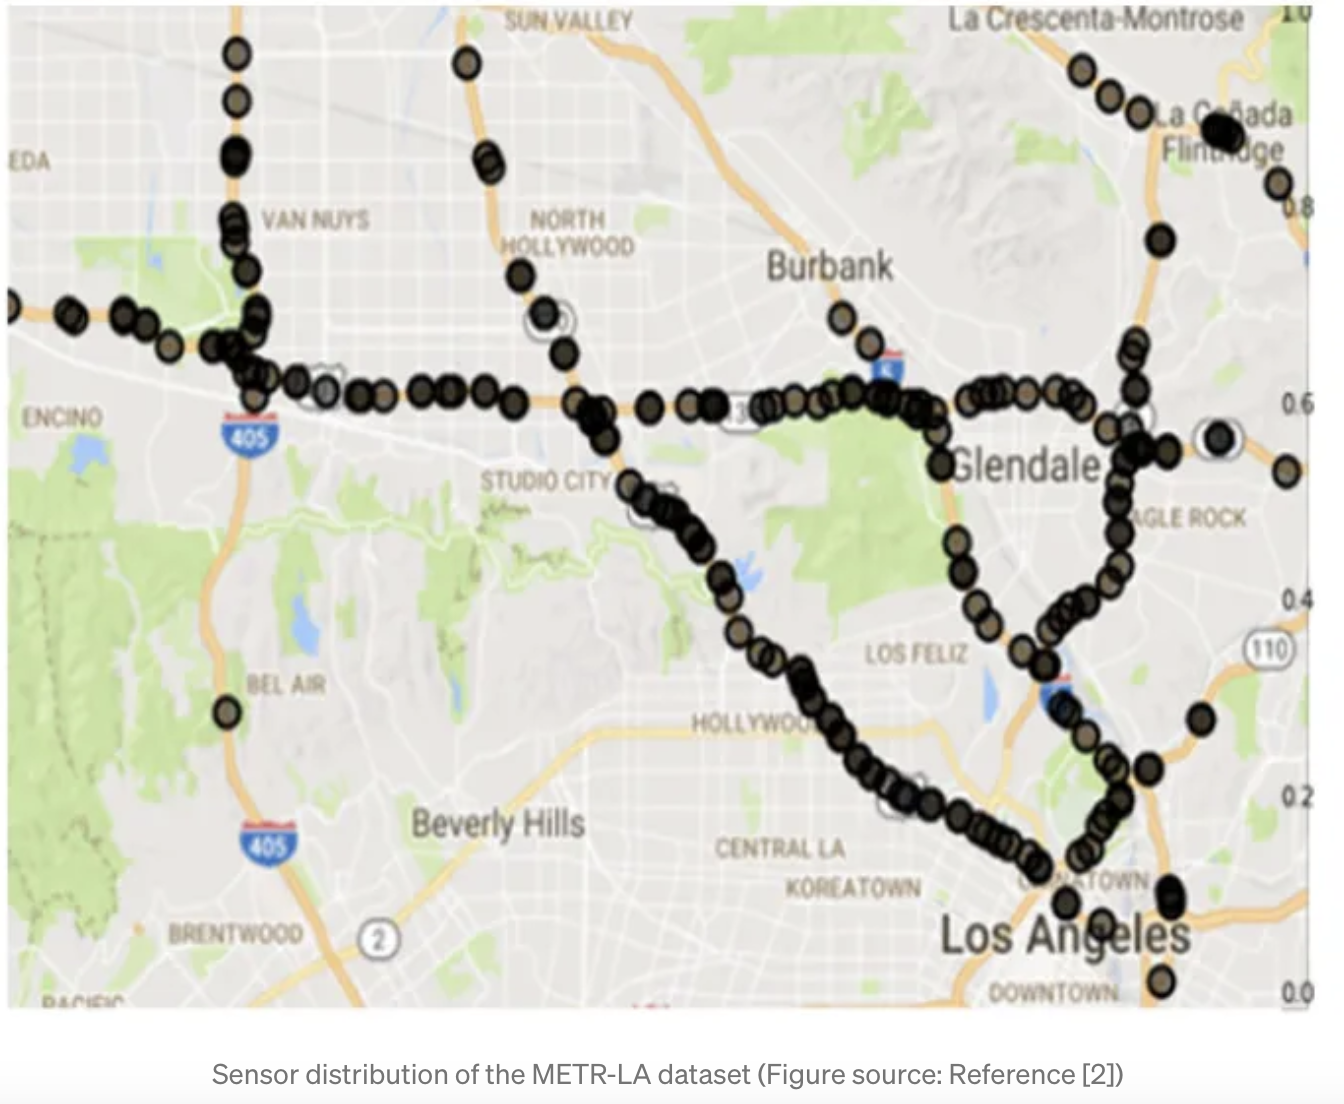 -->
<img src="plots/metr-la_city.png" alt="image" width="600">

In [87]:
# load the outlier score for haugue dataset
data_name = 'METR-LA'
model_name = 'PW-AE_EMD'
with open(f'../results/{data_name}/outlier_scores/{model_name}/correlated_results.pickle', 'rb') as f:
    correlated_results = pickle.load(f)

In [96]:
df = correlated_results['df']
df = df.round(2)
df.corr()

717508    772151    767366    769405    769388    716951    717497  \
717508  1.000000  0.637395  0.655025  0.311698  0.510666  0.619454  0.733612   
772151  0.637395  1.000000  0.759431  0.339121  0.623312  0.686244  0.709333   
767366  0.655025  0.759431  1.000000  0.377892  0.660380  0.721777  0.746517   
769405  0.311698  0.339121  0.377892  1.000000  0.343419  0.342097  0.367472   
769388  0.510666  0.623312  0.660380  0.343419  1.000000  0.653458  0.601241   
...          ...       ...       ...       ...       ...       ...       ...   
717458  0.702627  0.683759  0.732813  0.334402  0.588981  0.688507  0.792563   
717465  0.594458  0.660999  0.716760  0.352400  0.667107  0.753088  0.733352   
717459  0.568096  0.661099  0.731554  0.356429  0.692761  0.738453  0.714691   
716960  0.706579  0.743607  0.781214  0.369403  0.651795  0.829544  0.793166   
769346  0.628949  0.689940  0.770977  0.359292  0.706237  0.763418  0.752629   

          717483    717468    772596  ...    773916    767750    717504  \
717508  0.560311  0.560394  0.666398  ...  0.697620  0.672936  0.773168   
772151  0.654086  0.699967  0.706169  ...  0.653141  0.790467  0.705885   
767366  0.725898  0.737989  0.772791  ...  0.703531  0.835528  0.695940   
769405  0.359855  0.348656  0.392778  ...  0.374051  0.362009  0.323736   
769388  0.696359  0.631330  0.712766  ...  0.657531  0.676519  0.525934   
...          ...       ...       ...  ...       ...       ...       ...   
717458  0.640692  0.672338  0.742909  ...  0.709628  0.750683  0.639674   
717465  0.815204  0.702938  0.804302  ...  0.787833  0.753470  0.622890   
717459  0.833795  0.721864  0.804617  ...  0.765334  0.751274  0.617046   
716960  0.711041  0.736568  0.782238  ...  0.758108  0.828126  0.683849   
769346  0.805050  0.740724  0.847919  ...  0.801988  0.790526  0.656947   

          717510    716949    717458    717465    717459    716960    769346  
717508  0.768475  0.732406  0.702627  0.594458  0.568096  0.706579  0.628949  
772151  0.647249  0.671764  0.683759  0.660999  0.661099  0.743607  0.689940  
767366  0.663349  0.701071  0.732813  0.716760  0.731554  0.781214  0.770977  
769405  0.355070  0.321789  0.334402  0.352400  0.356429  0.369403  0.359292  
769388  0.571824  0.672441  0.588981  0.667107  0.692761  0.651795  0.706237  
...          ...       ...       ...       ...       ...       ...       ...  
717458  0.709435  0.747635  1.000000  0.664838  0.658938  0.746764  0.716972  
717465  0.662122  0.735074  0.664838  1.000000  0.868994  0.712799  0.793438  
717459  0.627426  0.718179  0.658938  0.868994  1.000000  0.703577  0.811078  
716960  0.753968  0.846040  0.746764  0.712799  0.703577  1.000000  0.760349  
769346  0.676124  0.784671  0.716972  0.793438  0.811078  0.760349  1.000000  

[207 rows x 207 columns]

### -------- Check for top/mid/bottom 10 correlated features with target variable ---------

In [99]:
# top correlated intersections to 771673
df.corr().round(2)['771673'].sort_values(ascending=False)[1:10]

771667    0.95
772513    0.90
717460    0.88
765164    0.82
773974    0.81
717572    0.81
717445    0.81
716328    0.81
767751    0.80
Name: 771673, dtype: float64

In [100]:
# top anti-correlated intersections
df.corr().round(2)['771673'].sort_values(ascending=True)[1:10]

718076    0.15
774067    0.17
772669    0.31
769405    0.33
767471    0.33
767610    0.35
760987    0.35
763995    0.39
773013    0.44
Name: 771673, dtype: float64

In [101]:
# mid-correlated intersections
df.corr().round(2)['771673'].sort_values(ascending=False)[140:149]

772140    0.68
767620    0.67
717099    0.67
769431    0.67
717610    0.67
717502    0.67
717573    0.67
767470    0.67
765273    0.67
Name: 771673, dtype: float64

### -------- Plot correlated features with target variable ---------

In [102]:
sample_df = df.head(24*3)
fig = px.line(sample_df, x=sample_df.index, y=['771673','771667','769431','718076'], height=400, width=700, color_discrete_sequence=["blue", "red", "green", "mediumpurple"])
fig.update_yaxes(title_text="Outlier Score")
fig.update_xaxes(title_text="Time")
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99,
    orientation="h"
))
pio.write_image(fig, 'plots/outlier_metr_la.png',height=400, width = 700, scale=3)
fig.show()

In [103]:
sample_df = df.head(24*3)
fig = px.line(sample_df, x=sample_df.index, y=['771673','771667'], height=400, width=700, color_discrete_sequence=["blue", "red"])
fig.update_yaxes(title_text="Outlier Score")
fig.update_xaxes(title_text="Time")
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99,
    orientation="h"
))
fig.show()
pio.write_image(fig, 'plots/outlier_metr_0.png',height=400, width = 700, scale=4)

In [104]:
sample_df = df.head(24*3)
fig = px.line(sample_df, x=sample_df.index, y=['771673','769431'], height=400, width=700, color_discrete_sequence=["blue", "green"])
fig.update_yaxes(title_text="Outlier Score")
fig.update_xaxes(title_text="Time")
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99,
    orientation="h"
))
fig.show()
pio.write_image(fig, 'plots/outlier_metr_1.png',height=400, width = 700, scale=4)

In [105]:
sample_df = df.head(24*3)
fig = px.line(sample_df, x=sample_df.index, y=['771673','718076'], height=400, width=700, color_discrete_sequence=["blue", "mediumpurple"])
fig.update_yaxes(title_text="Outlier Score")
fig.update_xaxes(title_text="Time")
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99,
    orientation="h"
))
fig.show()
pio.write_image(fig, 'plots/outlier_metr_2.png',height=400, width = 700, scale=4)

### ------------ Heatmap for top/bottom 5 correlated features ------------

In [109]:
df.corr().round(2)['771673'].sort_values(ascending=False)[1:5].index

Index(['771667', '772513', '717460', '765164'], dtype='object')

In [110]:
# top anti-correlated intersections
df.corr().round(2)['771673'].sort_values(ascending=True)[1:5].index

Index(['718076', '774067', '772669', '769405'], dtype='object')

In [111]:
# heatmap with EMD loss
temp_df = df[['771673', '771667', '772513', '717460', '765164']+['718076', '774067', '772669', '769405'] ]
fig = px.imshow(temp_df.corr().round(2), text_auto=True, height=600, width=600)
pio.write_image(fig, 'plots/heatmap_emd.png',height=600, width = 600, scale=6)
fig.show()

In [113]:
# heatmap of correlation matrix
px.imshow(df.corr(), text_auto=True, height=600, width=600)

In [58]:
# heatmap with RMSE loss
temp_df = df[['771673', '771667', '717460', '717461', '772513'] + ['769418', '769405', '716939', '717481']]
fig = px.imshow(temp_df.corr().round(2), text_auto=True, height=600, width=600)
fig.show()
pio.write_image(fig, 'plots/metr-heatmap.png',height=600, width = 600, scale=6)


## ---------- 3. Correlation analysis PEMS-BAY ----------

In [132]:
# load the outlier score for haugue dataset
data_name = 'PEMS-BAY'
model_name = 'PW-AE_EMD'
with open(f'../results/{data_name}/outlier_scores/{model_name}/correlated_results.pickle', 'rb') as f:
    correlated_results = pickle.load(f)

In [133]:
df = correlated_results['df']
df.corr()

401891    402368    407204    401846    407364    407370    401926  \
401891  1.000000 -0.064675  0.168793  0.280474  0.105963  0.228872  0.261167   
402368 -0.064675  1.000000 -0.043924 -0.096784 -0.082042 -0.085082  0.023048   
407204  0.168793 -0.043924  1.000000  0.193970  0.143806  0.159915  0.105106   
401846  0.280474 -0.096784  0.193970  1.000000  0.126230  0.517713  0.234418   
407364  0.105963 -0.082042  0.143806  0.126230  1.000000  0.105759  0.101312   
...          ...       ...       ...       ...       ...       ...       ...   
407157  0.034104 -0.027715  0.081382  0.043425  0.065939  0.046592  0.051194   
407341 -0.096587  0.413828  0.010582 -0.107365 -0.091276 -0.086594  0.020319   
402365  0.242001 -0.079305  0.166692  0.221209  0.327463  0.188118  0.106780   
402371  0.242428  0.006500  0.135618  0.217797  0.182630  0.201209  0.208389   
402359 -0.014832  0.107335  0.050000 -0.040323 -0.019152 -0.024048  0.045231   

          404453    400147    407172  ...    407194    400823    407180  \
401891  0.027697  0.158752  0.038796  ... -0.007356  0.197066 -0.044053   
402368  0.043971  0.078018  0.016661  ...  0.274914 -0.100314  0.223172   
407204 -0.025684  0.106431  0.160021  ...  0.089026  0.222348  0.033978   
401846 -0.006442  0.105566  0.066484  ... -0.042387  0.293230 -0.050946   
407364 -0.001160  0.057569  0.014338  ... -0.031962  0.243788 -0.048970   
...          ...       ...       ...  ...       ...       ...       ...   
407157 -0.047303  0.101786  0.160870  ...  0.051987  0.061078  0.087881   
407341  0.093691  0.049440  0.101174  ...  0.259946 -0.129769  0.185899   
402365 -0.011796  0.115069  0.014656  ... -0.009409  0.333858 -0.044718   
402371  0.052949  0.169393 -0.023505  ...  0.038309  0.210016  0.005570   
402359  0.015541  0.041173  0.047654  ...  0.081168 -0.044047  0.104574   

          400837    404462    407157    407341    402365    402371    402359  
401891  0.244190  0.033541  0.034104 -0.096587  0.242001  0.242428 -0.014832  
402368 -0.014030 -0.051345 -0.027715  0.413828 -0.079305  0.006500  0.107335  
407204  0.127811  0.117831  0.081382  0.010582  0.166692  0.135618  0.050000  
401846  0.233949  0.133666  0.043425 -0.107365  0.221209  0.217797 -0.040323  
407364  0.240564  0.058848  0.065939 -0.091276  0.327463  0.182630 -0.019152  
...          ...       ...       ...       ...       ...       ...       ...  
407157  0.042588  0.122602  1.000000 -0.002052  0.067778  0.041894  0.007155  
407341 -0.046302 -0.051806 -0.002052  1.000000 -0.101298 -0.052511  0.177007  
402365  0.303678  0.072148  0.067778 -0.101298  1.000000  0.234664 -0.026362  
402371  0.210462 -0.045233  0.041894 -0.052511  0.234664  1.000000 -0.024503  
402359 -0.012663  0.028622  0.007155  0.177007 -0.026362 -0.024503  1.000000  

[325 rows x 325 columns]

In [134]:
# top correlated intersections
df.corr()['401906'].sort_values(ascending=False)[1:10]

401891    0.922787
400160    0.730602
402363    0.544077
400109    0.466447
400440    0.461478
400743    0.347010
404586    0.342888
407374    0.340545
401391    0.337541
Name: 401906, dtype: float64

In [135]:
# top correlated intersections
df.corr()['401906'].sort_values(ascending=True)[1:10]

407336   -0.088685
407342   -0.083916
407341   -0.081091
400168   -0.080162
407331   -0.078631
400911   -0.075875
407321   -0.074979
407328   -0.073824
400790   -0.072292
Name: 401906, dtype: float64

In [136]:
sample_df = df.head(24*5)
px.line(sample_df, x=sample_df.index, y=['401906','401891','407336'], title='Outliers correlation analysis' )

In [137]:
# heatmap
df = df[['401891','401906','402368']]
px.imshow(df.corr(), text_auto=True, height=600, width=600)

# --------- END -----------